# ENCODE bigWig analysis questions

Do your best to answer all parts of each question. You are encouraged to collaborate, but should turn in your own answers. 

Please limit each answer to a maximum of one markdown cell, one code cell and one plot. 

Put helper functions into a separate script (e.g. `hwutils.py`) so the notebook can be focused on plotting. Also see the [workshop on Clean Code](https://drive.google.com/file/d/1TraVwRkbkCbHq-s_-NS69ZEbRNwH8XNh/view) from Dan Larremore (https://larremorelab.github.io/slides/) for good coding tips to use in this assignment.


I collaborated with Allen, Yumin, and Qifan (in limited extent).

In [33]:
# useful libraries to import

import pandas as pd
import numpy as np

import  sklearn.decomposition
from sklearn import manifold

import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b') 
# nice way to format ticks as human-readable: ax.xaxis.set_major_formatter(bp_formatter)

from hwutils import *

In [35]:
# load dataFrame of bigWigs from ENCODE (encodeproject.org/), binned to 10kb resolution across chromosome 10.
# note that the first three columns are chrom,start,end and the other columns are labeled by bigWig file accession.
df = pd.read_table('./data/ENCODE_GRCh38_binned_subset.tsv')

# load metadata from ENCODE for bigwig files. 
# can be queried as follows: bigwig_metadata.query("`File accession`==@ df_column_name ")
bigwig_metadata = pd.read_table('./data/ENCODE_GRCh38_bigWig_metadata.tsv')

- After loading the data (above), and visualize some of the profiles. Why might many signals dip on chr10 at around 40Mb?


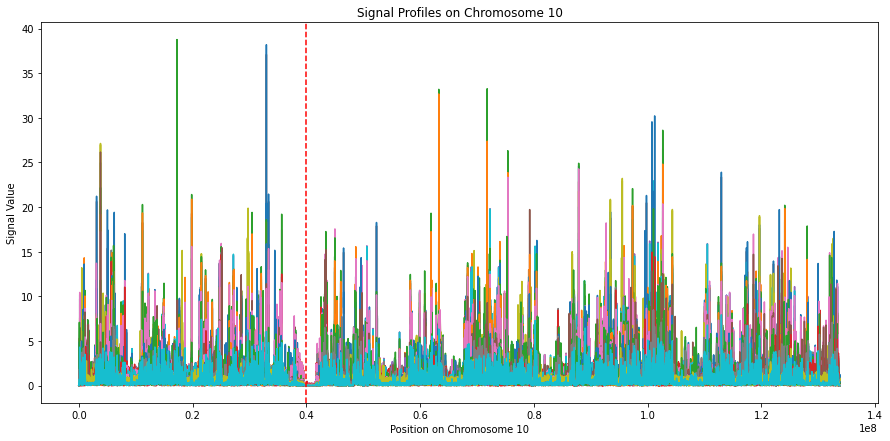

In [36]:
plt.figure(figsize=(15, 7))

# Iterating through columns and plotting them
for col in df.columns[3:]:
    plt.plot(df['start'], df[col], label=col)

x_position = df.iloc[3999]['start']
plt.axvline(x=x_position, color='red', linestyle='--', linewidth=1.5)

plt.title('Signal Profiles on Chromosome 10')
plt.xlabel('Position on Chromosome 10')
plt.ylabel('Signal Value')
plt.show()


A1: I suspect that the region on chromosome 10 with a low ChIP-seq signal corresponds to the centromere. The centromeric region is typically devoid of protein binding relevant for transcriptional activities.

- Use scikit-learn to perform PCA, and make a scatterplot of PC1 vs PC2.


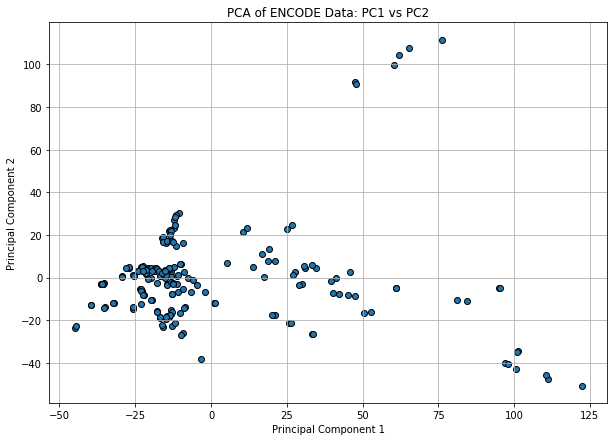

In [37]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

data_to_pca = df.drop(columns=['chrom', 'start', 'end']) 
data_transposed = data_to_pca.T

# Perform PCA
pca = PCA(n_components=2)  # We want the first two principal components
principal_components = pca.fit_transform(data_transposed)

# Convert the principal components to a DataFrame for easier plotting
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Plotting PC1 vs PC2
plt.figure(figsize=(10, 7))
plt.scatter(pca_df['PC1'], pca_df['PC2'], edgecolor='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of ENCODE Data: PC1 vs PC2')
plt.grid(True)
plt.show()

- Try to use the experiment metadata to understand and remove outliers. Try labeling or coloring points by various metadata columns. Were any columns in the metadata useful for outlier removal? Note that `sklearn.preprocessing.LabelEncoder()` can be useful for transforming text strings to categories, and `plt.text` can be used to overlay labels with points.

<ipython-input-38-e3334acea01f>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_biosamples))


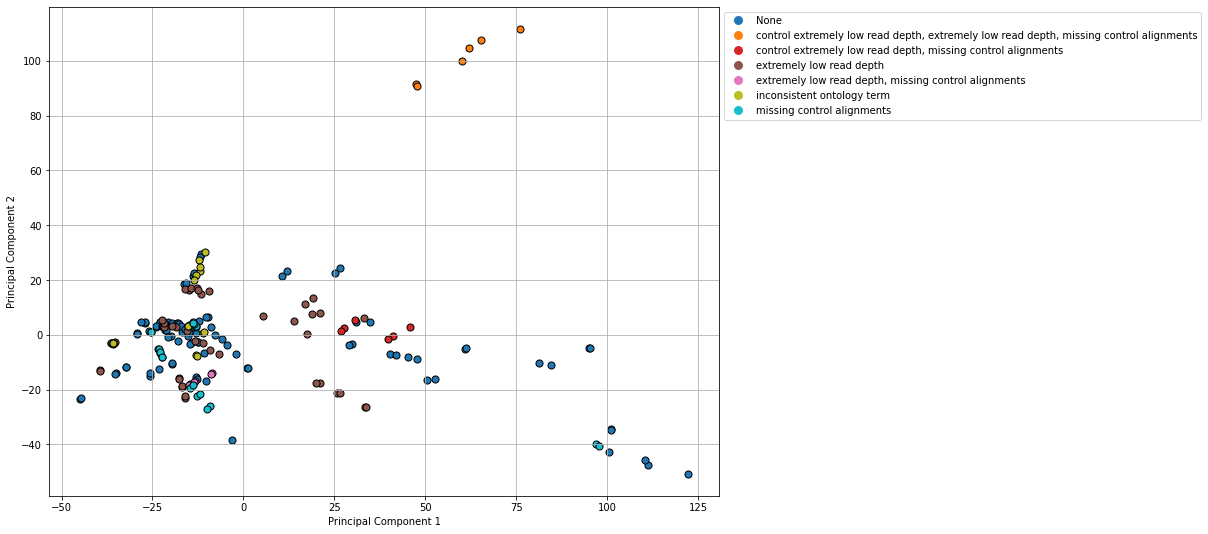

In [38]:
from sklearn.preprocessing import LabelEncoder
from matplotlib.lines import Line2D

file_accession_to_biosample = dict(zip(bigwig_metadata["File accession"], bigwig_metadata["Audit ERROR"]))

biosample_labels = data_transposed.index.map(file_accession_to_biosample)

label_encoder = LabelEncoder()
color_labels = label_encoder.fit_transform(biosample_labels)

# Get unique biosample labels and assign a color to each
unique_biosamples = label_encoder.classes_
colors = plt.cm.get_cmap('tab10', len(unique_biosamples))

fig, ax = plt.subplots(figsize=(12, 9))

for biosample, color_idx in zip(unique_biosamples, range(len(unique_biosamples))):
    mask = color_labels == color_idx
    ax.scatter(pca_df['PC1'][mask], pca_df['PC2'][mask], color=colors(color_idx), edgecolor='k', s=50, label=biosample)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.grid(True)

# Create a legend and move it outside
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors(color_idx), markersize=10, label=biosample) for biosample, color_idx in zip(unique_biosamples, range(len(unique_biosamples)))]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


A3. I think PCA with Audit ERROR label is the most useful category. This shows that a major outlier group is in control extremely low read depth, extremely low read depth, and missing control alignments have very different pattern. This makes sense, since they are exceptionally poor quality data.

- Which Assays or Experiment Targets show broad vs narrow patterns? Is this consistent across cell types? Does this relate to the patterns seen in PCA? One way to investigate the characteristic scale is by computing the autocorrelation.


{'CTCF-human': 'narrow', 'H3K27ac-human': 'narrow', 'HDAC6-human': 'broad', 'H3K4me2-human': 'narrow', 'H3K79me2-human': 'narrow', 'EBF1-human': 'narrow', 'SP1-human': 'broad', 'E2F6-human': 'narrow', 'MAFK-human': 'broad', 'ZNF274-human': 'broad', 'H3K4me3-human': 'narrow', 'H3K9me3-human': 'narrow', 'IRF3-human': 'broad', 'FOS-human': 'narrow', 'RBBP5-human': 'narrow', 'POLR2AphosphoS5-human': 'narrow', 'USF1-human': 'broad', 'RAD21-human': 'narrow', 'TAF1-human': 'broad', 'MAX-human': 'broad', 'SRF-human': 'broad', 'MXI1-human': 'broad', 'H3K9ac-human': 'narrow', 'JUND-human': 'broad', 'ZBTB33-human': 'broad', 'REST-human': 'narrow', 'ATF3-human': 'broad', 'EZH2-human': 'narrow', 'CREB1-human': 'broad', 'H3K36me3-human': 'narrow', 'H2AFZ-human': 'narrow', 'NFE2-human': 'broad', 'H3K27me3-human': 'narrow', 'ELK4-human': 'broad', 'YY1-human': 'narrow', 'MEF2C-human': 'broad', 'USF2-human': 'broad', 'MYC-human': 'broad', 'H3K9me1-human': 'narrow', 'ZNF331-human': 'broad', 'SIX1-human':

<ipython-input-64-4594bf2b2849>:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20b")


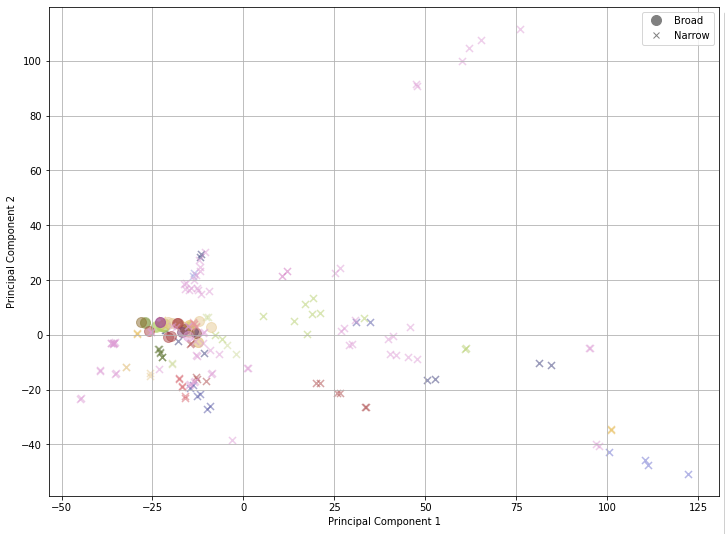

In [64]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from matplotlib.lines import Line2D

# Define a function to compute autocorrelation
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    normed_result = result[result.size // 2:] / result[result.size // 2]
    return normed_result

# Define a function to compute the half-life of autocorrelation
def compute_half_life(ac_values):
    initial_value = ac_values[0]
    half_value = initial_value / 2
    for lag, value in enumerate(ac_values):
        if value <= half_value:
            return lag
    return None

# Filter the bigwig_metadata DataFrame based on df columns
filtered_bigwig_metadata = bigwig_metadata[bigwig_metadata['File accession'].isin(df.columns)]

# Create a dictionary where keys are experiment targets and values are lists of associated file accessions
file_target_to_accession = {}
for _, row in filtered_bigwig_metadata.iterrows():
    target = row['Experiment target']
    accession = row['File accession']
    if target not in file_target_to_accession:
        file_target_to_accession[target] = []
    file_target_to_accession[target].append(accession)

# Compute autocorrelation for each target
autocorr_values = {}
for target, accessions in file_target_to_accession.items():
    combined_series = np.zeros(df.shape[0])
    for accession in accessions:
        combined_series += df[accession].values
    ac = autocorr(combined_series / len(accessions))
    autocorr_values[target] = ac

# Compute half-life for each target
half_life_values = {}
for target, values in autocorr_values.items():
    half_life = compute_half_life(values)
    half_life_values[target] = half_life

# Define a threshold for categorizing as broad or narrow
half_life_threshold = np.median(list(half_life_values.values()))

# Categorize targets as broad or narrow based on the threshold
pattern_classification_half_life = {}
for target, half_life in half_life_values.items():
    if half_life <= half_life_threshold:
        pattern_classification_half_life[target] = "narrow"
    else:
        pattern_classification_half_life[target] = "broad"

# Print the pattern classification
print(pattern_classification_half_life)

# Map file accessions to their cell type
file_accession_to_celltype = dict(zip(bigwig_metadata["File accession"], bigwig_metadata["Biosample term name"]))

# Map data_transposed index to target labels
celltype_labels = data_transposed.index.map(file_accession_to_celltype)

# Encode the cell type labels for color-coding
label_encoder = LabelEncoder()
color_labels = label_encoder.fit_transform(celltype_labels)

# Map pattern labels ('broad' or 'narrow')
pattern_labels = [pattern_classification_half_life[file_accession_to_target[accession]] for accession in data_transposed.index]

# Define markers for 'broad' and 'narrow'
markers = ['o' if pattern == "broad" else 'x' for pattern in pattern_labels]

# Use a distinct color palette (tab20b)
colors = plt.cm.get_cmap("tab20b")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 9))

# Scatter plot points with different colors and markers based on cell type and pattern
for color, celltype in zip(colors(range(len(label_encoder.classes_))), label_encoder.classes_):
    for marker in ['o', 'x']:
        mask = np.logical_and(np.array(markers) == marker, np.array(celltype_labels) == celltype)
        marker_size = 100 if marker == 'o' else 50
        # Add alpha (transparency) to the markers
        if marker == 'o':
            ax.scatter(pca_df['PC1'][mask], pca_df['PC2'][mask], color=color, edgecolor=color, s=marker_size, marker=marker, alpha=0.5)
        else:
            ax.scatter(pca_df['PC1'][mask], pca_df['PC2'][mask], color=color, s=marker_size, marker=marker, alpha=0.5)

# Set labels for the x and y axes
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')

# Create a legend for pattern (Broad and Narrow)
pattern_legend = [Line2D([0], [0], color='gray', marker='o', linestyle='None', markersize=10),
                  Line2D([0], [0], color='gray', marker='x', linestyle='None', markersize=6)]
legend1 = ax.legend(pattern_legend, ['Broad', 'Narrow'], loc="upper right")

# Create a legend for cell types and move it outside the plot
legend2_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=celltype) for color, celltype in zip(colors(range(len(label_encoder.classes_))), label_encoder.classes_)]
legend2 = ax.legend(handles=legend2_elements, loc="upper left", bbox_to_anchor=(1, 1))

# Add both legends back to the plot
ax.add_artist(legend1)
ax.add_artist(legend2)

# Add grid lines
ax.grid(True)

# Adjust layout and display the plot
plt.show()

A4: In the provided code, autocorrelation analysis was used to investigate whether Experiment Targets exhibited "broad" or "narrow" patterns based on the decay rate (higher vs. lower than the median). This analysis categorized Experiment Targets based on the half-life of their autocorrelation functions, which quantifies the characteristic scale of temporal correlation. The results were then visualized in a scatter plot, with cell types color-coded and patterns denoted by markers. 

Clearly, the experimental targets with broader patterns cluster together, roughly irrespective of the specific cell types they come from (although you can also see cell type-specific clustering as well). On the other hand, the narrow pattern targets scatter widely, often clustering in different parts of the PCA space. Here, cell-type specific clustering pattern is also observed, although broad vs. narrow generally segregate regardless of the specific cell type information. 

- Which "Experiment Targets" (e.g. histone marks or transcription factors) for which cell types are nearby in this PC1 vs PC2 space? Do any of these proximities have plausible biological interpretations? For example, are any polycomb-related factors in proximity? Illustrate this in a plot.


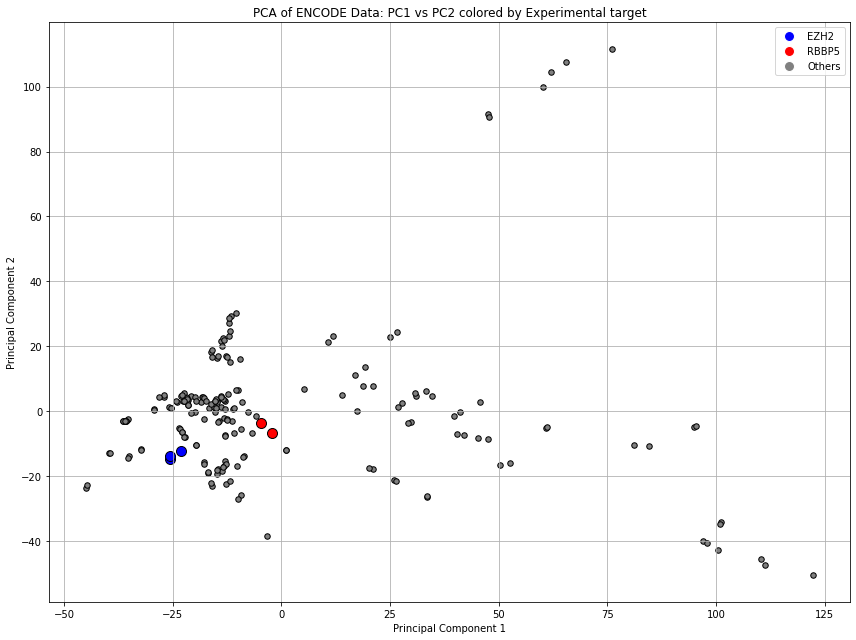

In [45]:
# 1. Create a dictionary that maps each file accession to its 'Experiment target'
file_accession_to_target = dict(zip(bigwig_metadata["File accession"], bigwig_metadata["Experiment target"]))

# 2. Map the data_transposed.index to 'Experiment target'
target_labels = data_transposed.index.map(file_accession_to_target)

# 3. Color code: "EZH2" and "RBBP5" in distinct colors, everything else in gray
colors = []
marker_sizes = []  # Initialize a list for marker sizes
for label in target_labels:
    if label == 'EZH2-human':
        colors.append('blue')  # blue for EZH2
        marker_sizes.append(100)  # Increase marker size for EZH2
    elif label == 'RBBP5-human':
        colors.append('red')  # red for RBBP5
        marker_sizes.append(100)  # Increase marker size for RBBP5
    else:
        colors.append('gray')  # gray for others
        marker_sizes.append(30)  # Reduce marker size for others

# 4. Plot the PCA data with colors and marker sizes representing the 'Experiment target' of interest
plt.figure(figsize=(12, 9))
for idx, row in pca_df.iterrows():
    plt.scatter(row['PC1'], row['PC2'], color=colors[idx], edgecolor='k', s=marker_sizes[idx])

# Legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='EZH2', markersize=10, markerfacecolor='blue'),
                   Line2D([0], [0], marker='o', color='w', label='RBBP5', markersize=10, markerfacecolor='red'),
                   Line2D([0], [0], marker='o', color='w', label='Others', markersize=10, markerfacecolor='gray')]
plt.legend(handles=legend_elements, loc='upper right')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of ENCODE Data: PC1 vs PC2 colored by Experimental target')
plt.grid(True)
plt.tight_layout()
plt.show()


A5. Yes. The polycomb-related factors, including the RBBP5 and EZH-2 are relatively closely located in the PCA clusters. 



- How much does preprocessing matter? Try normalizing the variance per track and see if you arrive at similar or distinct conclusions. Try removing the region on chr10 mentioned above. Note that `sklearn.preprocessing.StandardScaler` could be useful for preprocessing. 


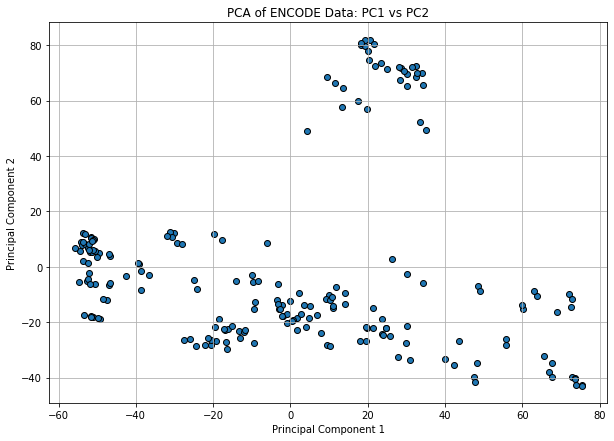

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Preprocess the data: Remove non-numeric columns and standardize
data_to_pca = df.drop(columns=['chrom', 'start', 'end']) 
data_to_pca = data_to_pca.drop(range(3999, 4151))

data_standardized = StandardScaler().fit_transform(data_to_pca)
data_transposed = data_standardized.T

# Perform PCA
pca = PCA(n_components=2)  # We want the first two principal components
principal_components = pca.fit_transform(data_transposed)

# Convert the principal components to a DataFrame for easier plotting
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Plotting PC1 vs PC2
plt.figure(figsize=(10, 7))
plt.scatter(pca_df['PC1'], pca_df['PC2'], edgecolor='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of ENCODE Data: PC1 vs PC2')
plt.grid(True)
plt.show()

A6: It reduced the issues with the outlier we had previously. 

- How many PCs are needed to explain 90% of the variance in the data? Illustrate this with a scree plot (https://en.wikipedia.org/wiki/Scree_plot). 


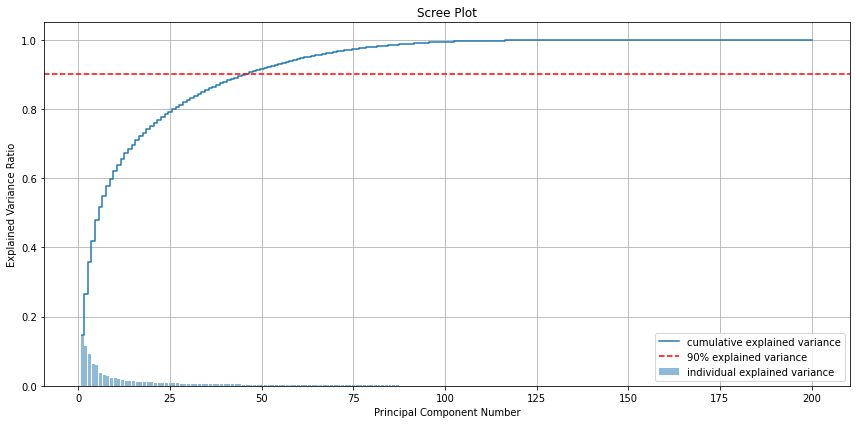

A7. To explain at least 90% of the variance, 45 principal components are needed.


In [10]:
# Step 1: Fit PCA on the data without specifying the number of components
pca_full = PCA()
pca_full.fit(data_transposed)

# Step 2: Calculate the cumulative explained variance
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Step 3: Plot the scree plot
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='cumulative explained variance')
plt.axhline(y=0.9, color='r', linestyle='--', label="90% explained variance")
plt.xlabel('Principal Component Number')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.legend(loc='best')
plt.tight_layout()
plt.grid(True)
plt.show()

# Step 4: Find number of components needed for 90% variance
num_components_90_variance = np.where(cumulative_variance >= 0.9)[0][0]
print(f"A7. To explain at least 90% of the variance, {num_components_90_variance} principal components are needed.")


- How different is the dimensionality reduction into two dimensions for PCA from that obtained using MDS (multi-dimensional scaling)? What methods could be used to determine the similarity? Illustrate with a plot.


/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


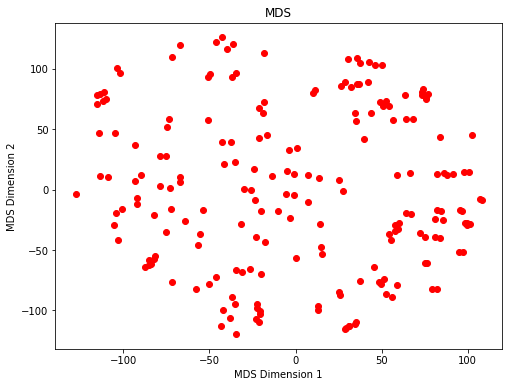

In [11]:
# Calculate the dissimilarity matrix based on Euclidean distances between data points
dissimilarity_matrix = np.sqrt(((data_transposed[:, None] - data_transposed) ** 2).sum(axis=2))

# Apply Multi-Dimensional Scaling (MDS) to reduce the dimensionality to two dimensions
mds = manifold.MDS(n_components=2, dissimilarity='precomputed')
X_mds = mds.fit_transform(dissimilarity_matrix)

# Plot the MDS representation
plt.figure(figsize=(8, 6))
plt.scatter(X_mds[:, 0], X_mds[:, 1], color='red', marker='o')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.title('MDS')
plt.show()


- Would non-negative matrix factorization (https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) be a useful method to use for this dataset? Why or why not?  (No plots needed for this question).


A9: NMF works best with datasets that only have positive values. It breaks down data into simpler parts that are easier to understand. For the ENCODE dataset, if all the data points are positive and we're looking for simpler, combined representations, NMF could work. It can be more advantageous because it can show additive patterns in the data that PCA cannot. I don't think the data itself contains negative values, so it should be possible to use implement.